In [1]:
%matplotlib inline
import tensorflow as tf
import dirt
import cv2
from scipy.io import loadmat
from menpo.image import Image
from menpo.shape import PointCloud, TriMesh

In [181]:
canvas_width, canvas_height = 128, 128
centre_x, centre_y = 32, 32
square_size = 16

# Build square in screen space
square_vertices = tf.constant([[0, 0], [0, 1], [1, 1], [1, 0]], dtype=tf.float32) * square_size - square_size / 2.
square_vertices += [centre_x, centre_y]

# Transform to homogeneous coordinates in clip space
square_vertices = square_vertices * 2. / [canvas_width, canvas_height] - 1.
square_vertices = tf.concat([square_vertices, tf.zeros([4, 1]), tf.ones([4, 1])], axis=1)

pixels = dirt.rasterise(
    vertices=square_vertices,
    faces=[[0, 1, 2], [0, 2, 3]],
    vertex_colors=tf.ones([4, 1]),
    background=tf.zeros([canvas_height, canvas_width, 1]),
    height=canvas_height, width=canvas_width, channels=1
)[:, :, 0]

with tf.Session() as sess:
    image = sess.run([pixels])
    image = image[0]
    
cv2.imshow('image', image)
cv2.waitKey(0)
# press any key to proceed
cv2.destroyAllWindows()    

In [193]:
import menpo3d.io as m3io
import pickle
import numpy as np
from copy import deepcopy


def ProjectShape(vertex, fR, T, roi_bbox):
    # function in pytorch 3DDFA
    STD_SIZE = 120
    
    # transform to image coordinate scale
    vertex = fR.dot(vertex) + T
    vertex[1,:] = STD_SIZE + 1 - vertex[1,:]
    
    sx, sy, ex, ey = roi_bbox
    scale_x = (ex - sx) / STD_SIZE
    scale_y = (ey - sy) / STD_SIZE
    vertex[0, :] = vertex[0, :] * scale_x + sx
    vertex[1, :] = vertex[1, :] * scale_y + sy

    s = (scale_x + scale_y) / 2
    vertex[2, :] *= s
    
    return vertex

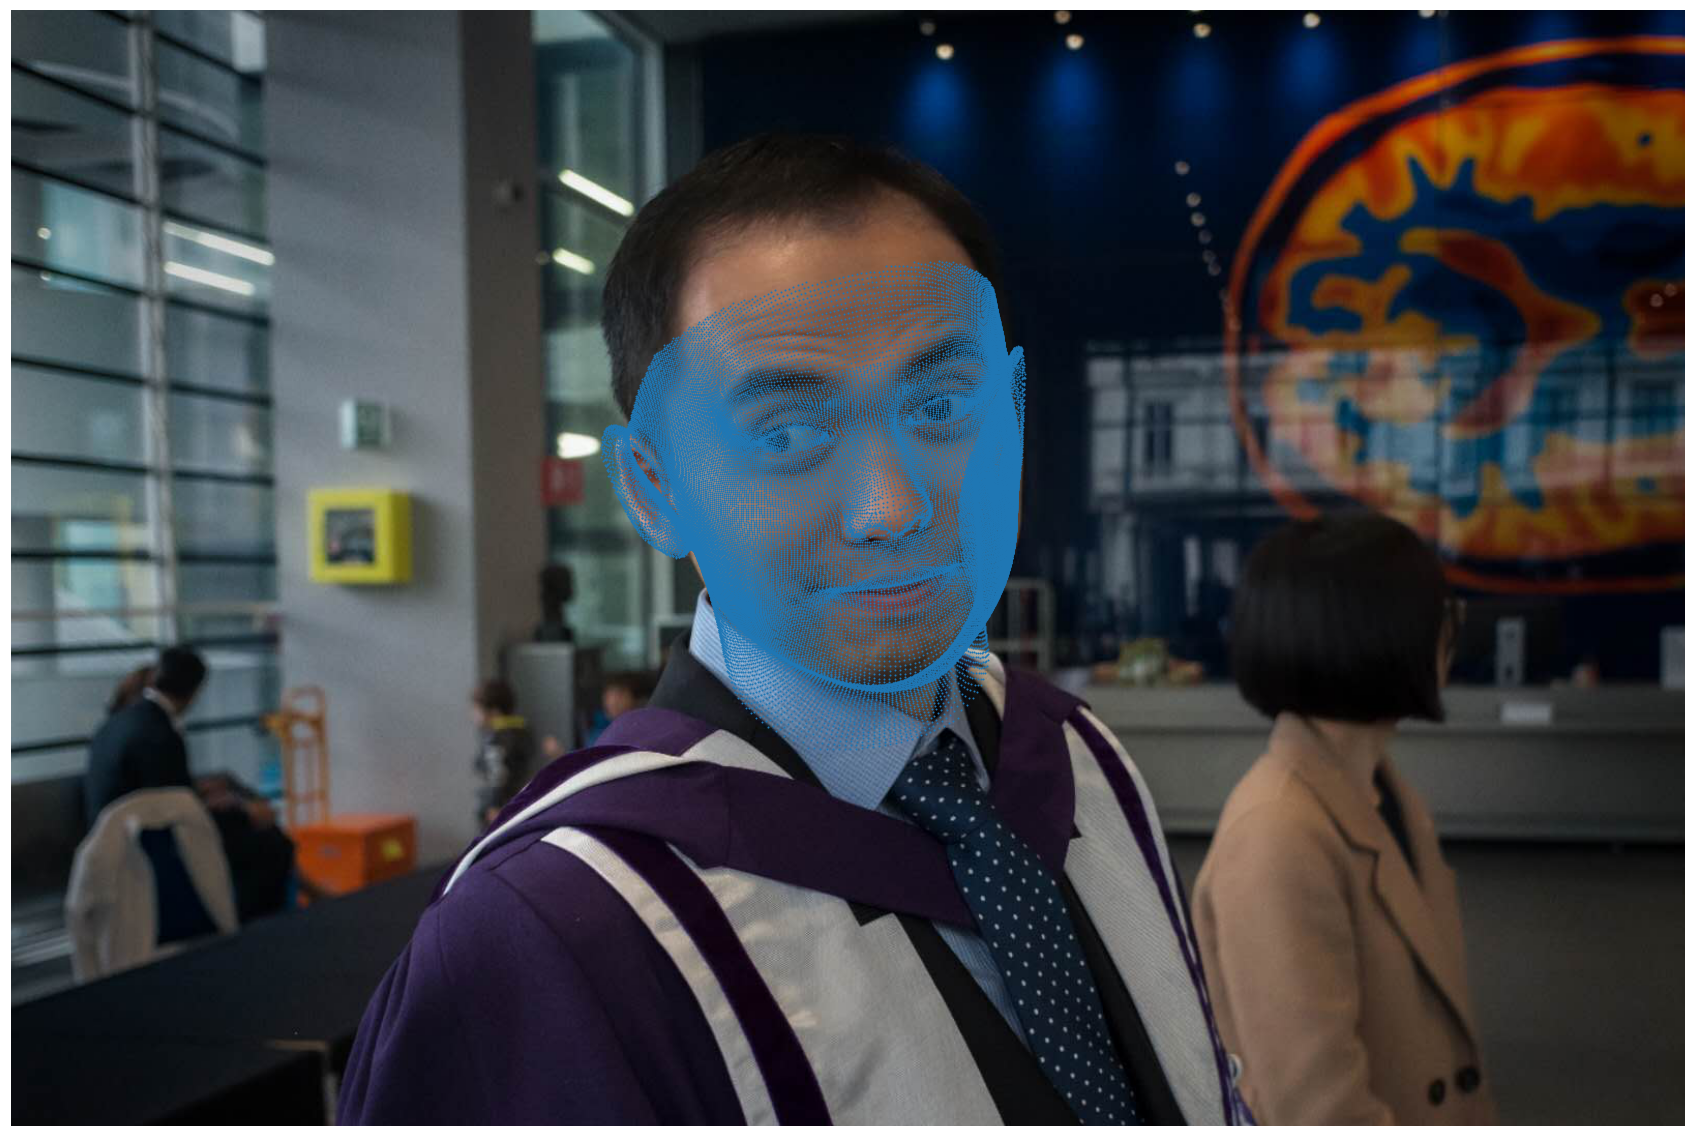

In [203]:
# extract parameters from the 3ddfa results
yaw, pitch, roll = data['face_pose']['yaw'], data['face_pose']['pitch'], data['face_pose']['roll']
vertex = data['vertex']
fR, T, roi_box = data['camera_transform']['fR'], data['camera_transform']['T'], data['roi_box']
vertex_projected = ProjectShape(vertex, fR, T, roi_box)

im = Image.init_from_channels_at_back(image[:,:,::-1])
im.landmarks['vertex'] = PointCloud(vertex_projected.T[:,:2][:,::-1])
im.view_landmarks(figure_size=(30,30), marker_size=1)

In [184]:
m_face_tri = loadmat('Model_face_tri.mat')
tri = deepcopy(m_face_tri['tri'] - 1).T

image_file = 'example_image_01.jpg'
image = cv2.imread(image_file)

result_file = 'example_image_01.pkl'
with open(result_file, 'rb') as f:
    data = pickle.load(f, encoding='latin1')

In [204]:
# extract parameters from the 3ddfa results
yaw, pitch, roll = data['face_pose']['yaw'], data['face_pose']['pitch'], data['face_pose']['roll']
vertex = data['vertex']
fR, T, roi_box = data['camera_transform']['fR'], data['camera_transform']['T'], data['roi_box']
vertex_projected = ProjectShape(vertex, fR, T, roi_box)

canvas_height, canvas_width, n_channel = image.shape

n_vertex = vertex.shape[1]
vertex_scaled = vertex_projected.T[:,:2]
# the image coordinate system is a bit different from us.
# the origin of an image is indeed (0, image_height)
vertex_scaled[:, 1] = canvas_height-vertex_scaled[:, 1]
vertex_scaled = vertex_scaled * 2. / [canvas_width, canvas_height] - 1.
tf_vertices = tf.concat([vertex_scaled, tf.zeros([n_vertex, 1]), tf.ones([n_vertex, 1])], axis=1)

tf_tri = tf.constant(tri, dtype=tf.int32)

pixels = dirt.rasterise(
            vertices=tf_vertices,
            faces=tf_tri,
            vertex_colors=tf.ones([n_vertex, n_channel]),
            background=tf.constant(image.astype(np.float32)/255.0),
            height=canvas_height, width=canvas_width, channels=n_channel
         )

with tf.Session() as sess:
    rendered_image = sess.run([pixels])
    rendered_image = rendered_image[0]
    
cv2.imshow('rendered_image', rendered_image)
cv2.waitKey(0)
cv2.destroyAllWindows()    

In [195]:
vertex_projected = ProjectShape(vertex, fR, T, roi_box)
vertex_scaled = vertex_projected.T[:,:2]
vertex_scaled

array([[686.92267, 398.89673],
       [687.1272 , 399.51288],
       [687.33813, 400.1277 ],
       ...,
       [919.433  , 468.9863 ],
       [918.65   , 468.11035],
       [917.8612 , 467.24884]], dtype=float32)

In [44]:
%matplotlib qt
import os

In [45]:
os.environ["QT_API"] = "pyqt"

In [46]:
TriMesh(vertex_projected.T, trilist=tri).view()

In [26]:
tf.ones([n_vertex, n_channel])

<tf.Tensor 'ones_6:0' shape=(53215, 3) dtype=float32>

In [54]:
len(image)

1

0.0

In [ ]:
cv2.imshow('image', image)
cv2.waitKey(0)

In [82]:
cv2.destroyAllWindows()